<a href="https://colab.research.google.com/github/isakimfv/TutorialesPython/blob/main/Predicci%C3%B3n_de_Acciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [127]:
# Paso 1: Importar Librerías
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Paso 2: Cargar el Dataset
path = "/content/drive/MyDrive/Colab Notebooks/WMT_1970-10-01_2025-01-31.csv"   # Dirección del archivo CSV con los datos
data = pd.read_csv(path, parse_dates=['Date'])                                  # Se lee el archivo CSV y se almacena en el Dataframe

# Mostrar las primeras filas del dataset
print(data.head())

        Date      Open      High       Low     Close  Adj Close   Volume
0 1972-08-25  0.021159  0.021566  0.021159  0.021484   0.011639  7526400
1 1972-08-28  0.021484  0.021647  0.021403  0.021403   0.011595  2918400
2 1972-08-29  0.021322  0.021322  0.021159  0.021159   0.011463  5836800
3 1972-08-30  0.021159  0.021159  0.020996  0.021159   0.011463  1228800
4 1972-08-31  0.020996  0.020996  0.020833  0.020833   0.011286  2611200


In [128]:
# Paso 3: Deliminar el alcanze del modelo
data = data[['Date','Open','Close']]                              # Tomamos las columnas Date, Open y Close
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date',drop=True,inplace=True)                               # Establecemos la columna Date como indice del Dataframe
data.head()                                                                 # Mostramos el Dataframe de nuevo

,Open,Close
Date,,
1972-08-25,0.021159,0.021484
1972-08-28,0.021484,0.021403
1972-08-29,0.021322,0.021159
1972-08-30,0.021159,0.021159
1972-08-31,0.020996,0.020833


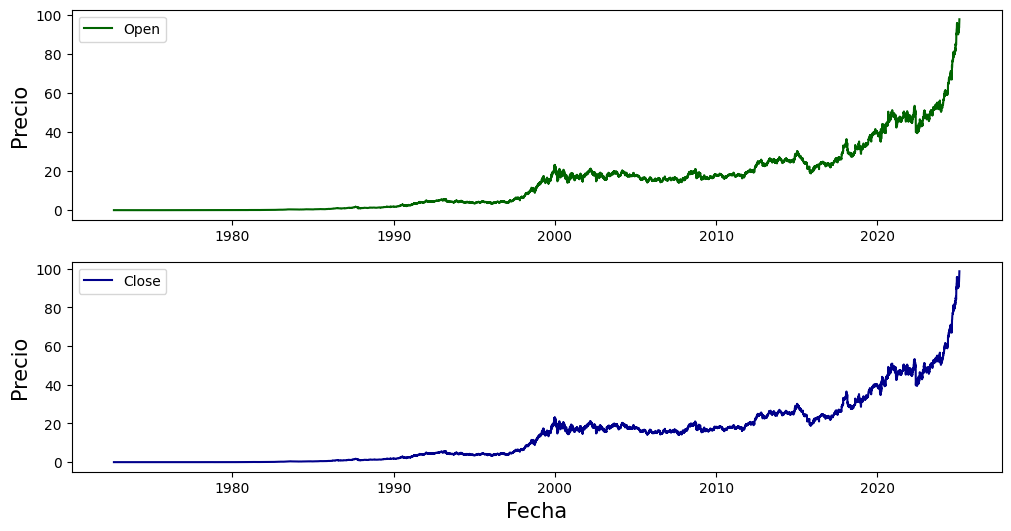

In [129]:
# Paso 4: Gráficar los valores de Open y Close de las acciones sobre el Plano del tiempo

fg, ax =plt.subplots(2,1,figsize=(12,6))
ax[0].plot(data['Open'],label='Open',color='darkgreen')
ax[0].set_ylabel('Precio',size=15)
ax[0].legend()
ax[1].plot(data['Close'],label='Close',color='darkblue')
ax[1].set_xlabel('Fecha',size=15)
ax[1].set_ylabel('Precio',size=15)
ax[1].legend()
fg.show()

In [130]:
# Paso 5: Preprocesamiento de datos
from sklearn.preprocessing import MinMaxScaler
Ms = MinMaxScaler()

data[data.columns] = Ms.fit_transform(data)     # Transforma todos los datos a una escala uniforme

training_size = round(len(data) * 0.80)         # Define la cantidad de datos que representan el 80% del set

train_data = data[:training_size]               # Separa los set de entranamiento y testing en 80/20 respectivamente
test_data  = data[training_size:]

In [131]:
# Paso 6: Se crea una función para la creación de las secuencias de entrenamiento y prueba. Separando los datos target de los valores que lo acompañan

def create_sequence(dataset):
  sequences = []
  labels = []
  start_idx = 0

  for stop_idx in range(50,len(dataset)):
    sequences.append(dataset.iloc[start_idx:stop_idx])
    labels.append(dataset.iloc[stop_idx])
    start_idx += 1
  return (np.array(sequences),np.array(labels))

train_seq, train_label = create_sequence(train_data)
test_seq, test_label = create_sequence(test_data)

In [132]:
print(len(data))
print(train_seq.shape)
print(train_label.shape)
print(test_seq.shape)
print(test_label.shape)

13218
(10524, 50, 2)
(10524, 2)
(2594, 50, 2)
(2594, 2)


In [133]:
test_data.head()

,Open,Close
Date,,
2014-07-29,0.256588,0.254869
2014-07-30,0.258875,0.252638
2014-07-31,0.252425,0.248583
2014-08-01,0.250139,0.248448
2014-08-04,0.250344,0.248448


In [134]:
# Paso 7: Importar librerías para la creación del modelo LSTM

from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional, Flatten

In [135]:
# Paso 8: Creación del modelo específicando las capas que lo componen

model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape = (train_seq.shape[1], train_seq.shape[2])))

model.add(Dropout(0.1))
model.add(LSTM(units=50))

model.add(Dense(2))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                        │ (None, 50, 50)              │          10,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 50, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,902 (120.71 KB)

 Trainable params: 30,902 (120.71 KB)

 Non-trainable params: 0 (0.00 B)

In [136]:
# Paso 9: Entrenamiento y ejecución de predicciones

model.fit(train_seq, train_label, epochs=80,validation_data=(test_seq, test_label), verbose=1)
test_predicted = model.predict(test_seq)
test_inverse_predicted = Ms.inverse_transform(test_predicted)

Epoch 1/80
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 9.6644e-04 - mean_absolute_error: 0.0133 - val_loss: 9.9548e-04 - val_mean_absolute_error: 0.0175
Epoch 2/80
329/329 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 2.1717e-05 - mean_absolute_error: 0.0029 - val_loss: 8.5499e-04 - val_mean_absolute_error: 0.0161
Epoch 3/80
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.1359e-05 - mean_absolute_error: 0.0030 - val_loss: 7.5476e-04 - val_mean_absolute_error: 0.0157
Epoch 4/80
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.1879e-05 - mean_absolute_error: 0.0032 - val_loss: 8.0657e-04 - val_mean_absolute_error: 0.0178
Epoch 5/80
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 1.8717e-05 - mean_absolute_error: 0.0028 - val_loss: 7.2521e-04 - val_mean_absolute_error: 0.0168
Epoch 6/80
329/329 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 1.8422e-05 - mean_absolute_error: 0.0028 - val_loss: 3.7582e-04 - val_mean_absolute_error: 0.0111
Epoch 7/80
329/329 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/ste

In [137]:
# Paso 10: Visualización de datos de predicción y datos reales
compared_data = pd.concat([data.copy(),pd.DataFrame(test_inverse_predicted,columns=['open_predicted','close_predicted'], index = data.index[-len(test_inverse_predicted):])], axis=1)
compared_data[['Open','Close']] = Ms.inverse_transform(compared_data[['Open','Close']])
compared_data = compared_data.dropna()
compared_data.head()

,Open,Close,open_predicted,close_predicted
Date,,,,
2014-10-08,25.803333,26.080000,26.079426,25.982681
2014-10-09,26.036667,25.953333,26.393215,26.291674
2014-10-10,25.976667,26.096666,26.276594,26.175997
2014-10-13,26.010000,25.853333,26.417551,26.321037
2014-10-14,25.943333,25.993334,26.179590,26.090443


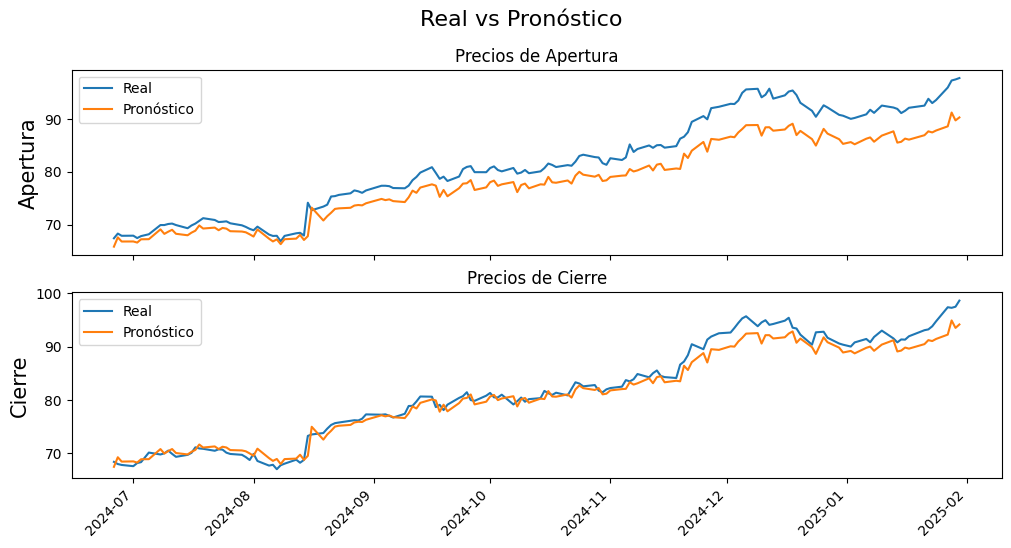

In [138]:
fg, ax =plt.subplots(2,1,figsize=(12,6))
fg.suptitle('Real vs Pronóstico', fontsize=16)
ax[0].set_title("Precios de Apertura")
ax[0].plot(compared_data[["Open","open_predicted"]].iloc[-150:])
ax[0].set_ylabel('Apertura',size=15)
ax[0].legend(["Real","Pronóstico"])

ax[1].set_title("Precios de Cierre")
ax[1].plot(compared_data[["Close","close_predicted"]].iloc[-150:])
ax[1].set_ylabel('Cierre',size=15)
ax[1].legend(["Real","Pronóstico"])

fg.autofmt_xdate(rotation=45)
fg.show()